In [1]:
# Import
from PIL import Image
import numpy as np
from matplotlib import cm

# Helper function to display an array as an image
def show_arr(arr):
    x, y = arr.shape
    arr2 = np.zeros((x, y, 2), dtype = int)
    arr2[:,:,0] = arr[:,:]
    arr2[:,:,1] = 255
    
    # If we display an 8x8 array, resize it to see better
    if x == 8 and y == 8:
        return Image.fromarray(np.uint8(arr2)).resize((500,500), Image.NEAREST)
    else:
        return Image.fromarray(np.uint8(arr2))

# Introduction

This notebook will take you throw different JPEG compression methods, explaining each step of the compression with examples of code and visuals.

It was written by:
* xxxx 
* yyyy
* ilan.guenet

All the required compression algorithm are implemented and shown working.

As required here you can adjust the quality used to compute the matrix of all the following examples. You can also specify the path of the picture that will be used.

In [2]:
q = 50
path = "randompic_color.png"

# Part 1: 8x8 grayscale matrix
Let's start by compressing a simple 8x8 grayscale matrix. Since it will be the core of the algorithm, it is important to have it done right.

We call this matrix `I`

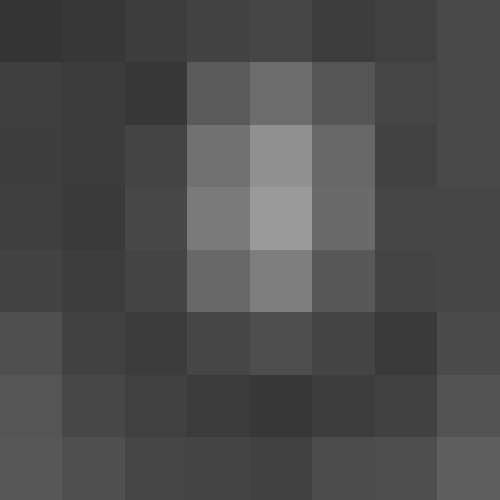

In [3]:
# Define a test array of 64 values
# This array will be used to test our algorithm, before we start working on real images
I = np.array([[52, 55, 61, 66, 70, 61, 64, 73],
                  [63, 59, 55, 90, 109 ,85, 69, 72],
                  [62, 59, 68, 113, 144, 104, 66, 73],
                  [63, 58, 71, 122, 154, 106, 70, 69],
                  [67, 61, 68, 104, 126, 88, 68, 70],
                  [79, 65, 60, 70, 77, 68, 58, 75],
                  [85, 71, 64, 59, 55, 61, 65, 83],
                  [87, 79, 69, 68, 65, 76, 78, 94]])

show_arr(I)

## Compression
### Compression step 1: DCT spectrum computation

Firstly, we compute the DCT 8x8 matrix.\
We call this matrix `D8`\
$$
D_8=\frac{1}{2}
\begin{pmatrix}
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\\
\cos{\frac{\pi}{16}} & \cos{\frac{3\pi}{16}} & \cos{\frac{5\pi}{16}} & \cos{\frac{7\pi}{16}} & \cos{\frac{9\pi}{16}} & \cos{\frac{11\pi}{16}} & \cos{\frac{13\pi}{16}} & \cos{\frac{15\pi}{16}} \\
\cos{\frac{2\pi}{16}} & \cos{\frac{6\pi}{16}} & \cos{\frac{10\pi}{16}} & \cos{\frac{14\pi}{16}} & \cos{\frac{18\pi}{16}} & \cos{\frac{22\pi}{16}} & \cos{\frac{26\pi}{16}} & \cos{\frac{30\pi}{16}} \\
\cos{\frac{3\pi}{16}} & \cos{\frac{9\pi}{16}} & \cos{\frac{15\pi}{16}} & \cos{\frac{21\pi}{16}} & \cos{\frac{27\pi}{16}} & \cos{\frac{33\pi}{16}} & \cos{\frac{39\pi}{16}} & \cos{\frac{45\pi}{16}} \\
\cos{\frac{4\pi}{16}} & \cos{\frac{12\pi}{16}} & \cos{\frac{20\pi}{16}} & \cos{\frac{28\pi}{16}} & \cos{\frac{36\pi}{16}} & \cos{\frac{44\pi}{16}} & \cos{\frac{52\pi}{16}} & \cos{\frac{60\pi}{16}} \\
\cos{\frac{5\pi}{16}} & \cos{\frac{15\pi}{16}} & \cos{\frac{25\pi}{16}} & \cos{\frac{35\pi}{16}} & \cos{\frac{45\pi}{16}} & \cos{\frac{55\pi}{16}} & \cos{\frac{65\pi}{16}} & \cos{\frac{75\pi}{16}} \\
\cos{\frac{6\pi}{16}} & \cos{\frac{18\pi}{16}} & \cos{\frac{30\pi}{16}} & \cos{\frac{42\pi}{16}} & \cos{\frac{54\pi}{16}} & \cos{\frac{66\pi}{16}} & \cos{\frac{78\pi}{16}} & \cos{\frac{90\pi}{16}} \\
\cos{\frac{7\pi}{16}} & \cos{\frac{21\pi}{16}} & \cos{\frac{35\pi}{16}} & \cos{\frac{49\pi}{16}} & \cos{\frac{63\pi}{16}} & \cos{\frac{77\pi}{16}} & \cos{\frac{91\pi}{16}} & \cos{\frac{105\pi}{16}} \\
\end{pmatrix}
$$

In other word,
$$
D_8[0, j] = \frac{1}{2\sqrt{2}}\\
D_8[i, j] = \frac{\cos(\pi * (i + 2 * i * j))}{2}
$$

Entries of `D8` are floating point numbers

In [4]:
def create_D8():
    D8 = np.zeros((8,8), dtype = float)
    D8[0,:] = 1 / np.sqrt(2)

    for i in range(1, 8):
        for j in range(8):
            D8[i,j] = np.cos(np.pi * (i + 2 * i * j) / 16)

    D8 /= 2
    return D8

D8 = create_D8()
D8

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.49039264,  0.41573481,  0.27778512,  0.09754516, -0.09754516,
        -0.27778512, -0.41573481, -0.49039264],
       [ 0.46193977,  0.19134172, -0.19134172, -0.46193977, -0.46193977,
        -0.19134172,  0.19134172,  0.46193977],
       [ 0.41573481, -0.09754516, -0.49039264, -0.27778512,  0.27778512,
         0.49039264,  0.09754516, -0.41573481],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.27778512, -0.49039264,  0.09754516,  0.41573481, -0.41573481,
        -0.09754516,  0.49039264, -0.27778512],
       [ 0.19134172, -0.46193977,  0.46193977, -0.19134172, -0.19134172,
         0.46193977, -0.46193977,  0.19134172],
       [ 0.09754516, -0.27778512,  0.41573481, -0.49039264,  0.49039264,
        -0.41573481,  0.27778512, -0.09754516]])

Then, we compute the DCT spectrum of the 8x8 matrix `I` with the DCT matrix `D8`.

We shift values by -128 to apply the DCT on `I` centered on its mean value. 

$$DCT(I - 128) = J = D_8(I - 128)D_8^T$$

Finally, we round the DCT spectrum. This is the first step of a lossy compression


In [5]:
J = D8 @ (I - 128) @ D8.T
J

array([[-4.15375000e+02, -3.01857173e+01, -6.11970620e+01,
         2.72393225e+01,  5.61250000e+01, -2.00951738e+01,
        -2.38764710e+00,  4.61815442e-01],
       [ 4.46552370e+00, -2.18574393e+01, -6.07580381e+01,
         1.02536368e+01,  1.31451101e+01, -7.08741801e+00,
        -8.53543671e+00,  4.87688850e+00],
       [-4.68344847e+01,  7.37059735e+00,  7.71293876e+01,
        -2.45619822e+01, -2.89116884e+01,  9.93352095e+00,
         5.41681547e+00, -5.64895086e+00],
       [-4.85349667e+01,  1.20683609e+01,  3.40997672e+01,
        -1.47594111e+01, -1.02406068e+01,  6.29596744e+00,
         1.83116505e+00,  1.94593651e+00],
       [ 1.21250000e+01, -6.55344993e+00, -1.31961210e+01,
        -3.95142773e+00, -1.87500000e+00,  1.74528445e+00,
        -2.78722825e+00,  3.13528230e+00],
       [-7.73474368e+00,  2.90546138e+00,  2.37979576e+00,
        -5.93931394e+00, -2.37779671e+00,  9.41391596e-01,
         4.30371334e+00,  1.84869103e+00],
       [-1.03067401e+00,  1.830674

In [6]:
J = np.around(J).astype(int)
J

array([[-415,  -30,  -61,   27,   56,  -20,   -2,    0],
       [   4,  -22,  -61,   10,   13,   -7,   -9,    5],
       [ -47,    7,   77,  -25,  -29,   10,    5,   -6],
       [ -49,   12,   34,  -15,  -10,    6,    2,    2],
       [  12,   -7,  -13,   -4,   -2,    2,   -3,    3],
       [  -8,    3,    2,   -6,   -2,    1,    4,    2],
       [  -1,    0,    0,   -2,   -1,   -3,    4,   -1],
       [   0,    0,   -1,   -4,   -1,    0,    1,    2]])

### Compression step 2: Quantization
We first need to create the matrix `Q`. It is possible to set a precision that will influence the compression level of the algorithm.
The default precision is 50. The compression gets more accurate when the precision gets higher. However, a high precision involve a lower compression.

In [7]:
def create_Q(q = 50):
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                  [12, 12, 14, 19, 26, 58, 60, 55],
                  [14, 13, 16, 24, 40, 57, 69, 56],
                  [14, 17, 22, 29, 51, 87, 80, 62],
                  [18, 22, 37, 56, 68, 109, 103, 77],
                  [24, 35, 55, 64, 81, 104, 113, 92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103, 99]])
    
    if q < 50:
        alpha = 5000 / q
    else:
        alpha = 200 - (2 * q)
        
    Q = (alpha * Q + 50) / 100
    Q = np.floor(Q).astype(int)
    
    return Q


Q = create_Q(q)
Q

array([[ 16,  11,  10,  16,  24,  40,  51,  61],
       [ 12,  12,  14,  19,  26,  58,  60,  55],
       [ 14,  13,  16,  24,  40,  57,  69,  56],
       [ 14,  17,  22,  29,  51,  87,  80,  62],
       [ 18,  22,  37,  56,  68, 109, 103,  77],
       [ 24,  35,  55,  64,  81, 104, 113,  92],
       [ 49,  64,  78,  87, 103, 121, 120, 101],
       [ 72,  92,  95,  98, 112, 100, 103,  99]])

The DCT spectrum `J` is quantized by the quantification matrix `Q` such as

$$K = \lfloor J . Q\rceil$$ with . as the element-wise division

Note: The result is rounded again. Many 0 will appear in `K`. Thus, we lost information again.

In [8]:
K = J / Q
K = np.around(K).astype(int)

K

array([[-26,  -3,  -6,   2,   2,   0,   0,   0],
       [  0,  -2,  -4,   1,   0,   0,   0,   0],
       [ -3,   1,   5,  -1,  -1,   0,   0,   0],
       [ -4,   1,   2,  -1,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

### Compression step 3: Linearization
It is time to take the quantizied matrix and transform it into a simple list, with the "zig-zag" format.

In [9]:
def zigzag(K):
    flippedK = K[::-1,:]
    zig = np.zeros((0), dtype = int)
    for k in range(1-K.shape[0], K.shape[0]):
        diagonalK = np.diagonal(flippedK, k)
        if k % 2 == 0:
            diagonalK = diagonalK[::-1]
        zig = np.concatenate([zig, diagonalK])
    return zig
    
zig = zigzag(K)
zig

array([-26,  -3,   0,  -3,  -2,  -6,   2,  -4,   1,  -4,   1,   1,   5,
         1,   2,   0,   0,  -1,   2,   0,   0,   0,   0,   0,  -1,  -1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

The array we get from the zig zag algorithm usually ends by a lot of 0. We can eliminate them to gain space.

In [10]:
def eliminate_zero(zig):
    zero_count = len(zig)
    for i in range(len(zig) - 1, -1, -1):
        if zig[i] != 0:
            zero_count = len(zig) - i - 1
            break

    return zig[:len(zig) - zero_count]

zig_without_zero = eliminate_zero(zig)
print("Ratio: ",  len(zig) / len(zig_without_zero))

Ratio:  2.4615384615384617


This is the end of the compression process. To recap, there are 3 steps to compress a 8x8 grayscale image:
   * DCT spectrum computation
   * Quantization
   * Linearization
   
At the end of the process, we obtain a list of numbers that doesn't end by 0. The 8x8 image is compressed into that list. In the JPEG compression algorithm, we are supposed to use Huffman in the linearization step. We ignore this last step.

The compression ratio is: $$ ratio_{compression} = \frac{length(I)}{length(zig\_zag)} = \frac{64}{length(zig\_zag)}$$ with the eliminated 0s zig_zag

In our example 8x8 image `I`, the compression ratio is 2.46

## Decompression

In the following part, the matrices starting with `_` are the same matrices as without the underscore but used in the decompression process.
For instance, `I` is the original matrix thus `_I` is the matrix after decompression. They supposed to look alike.

### Decompression step 1: Recreating the matrix

We first add back the trailings 0. This is simple because we know exactly how many 0 have been removed, since the original matrix contains 64 values.

Then, we need to recreate the 8x8 matrix from the list of values.

In [11]:
def read_zero(zig_without_zero):
    _zig = np.zeros((64), dtype=int)
    _zig[:len(zig_without_zero)] = zig_without_zero
    return _zig

_zig = read_zero(zig_without_zero)
_zig

array([-26,  -3,   0,  -3,  -2,  -6,   2,  -4,   1,  -4,   1,   1,   5,
         1,   2,   0,   0,  -1,   2,   0,   0,   0,   0,   0,  -1,  -1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [12]:
def zigzag_reverse(_zig):
    _K = np.zeros((8,8), dtype=int)
    x, y = 0, 0
    down = True
    # x -> column
    # y -> row
    maxY, maxX = _K.shape
    for v in _zig:
        _K[x, y] = v
        if down:
            x -= 1
            y += 1
            if x < 0:
                down = False
                x += 1
            if y >= maxY:
                down = False
                x += 2
                y -= 1
        else:
            x += 1
            y -= 1
            if x >= maxX:
                down = True
                x -= 1
                y += 2
            if y < 0:
                down = True
                y += 1
    return _K

_K = zigzag_reverse(_zig)
_K

array([[-26,  -3,  -6,   2,   2,   0,   0,   0],
       [  0,  -2,  -4,   1,   0,   0,   0,   0],
       [ -3,   1,   5,  -1,  -1,   0,   0,   0],
       [ -4,   1,   2,  -1,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

### Decompression step 2: Reverse quantization

$$\_J = \_K * Q$$ with * as the component-wise product

`_J` represents the DCT spectrum before quantization

In [13]:
_J = _K * Q
_J

array([[-416,  -33,  -60,   32,   48,    0,    0,    0],
       [   0,  -24,  -56,   19,    0,    0,    0,    0],
       [ -42,   13,   80,  -24,  -40,    0,    0,    0],
       [ -56,   17,   44,  -29,    0,    0,    0,    0],
       [  18,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

### Decompression step 3: Reverse DCT

As the final step of the decompression process, we must reverse the DCT matrix `_J` into a grayscale matrix `_I`. This grayscale matrix is the final matrix after decompression.

The reverse DCT is as following: $$\_I = DCT(\_J)^{-1} + 128 = (D_8^T\_JD_8) + 128$$

In [14]:
_I = (D8.T @ _J @ D8) + 128


### Time to see the results!
Now we have the compression and the decompression, let's see our result.
We will define a function to display an array.

In [15]:
# The function show_arr is defined at the very beginning of this document

Let's see the original array:

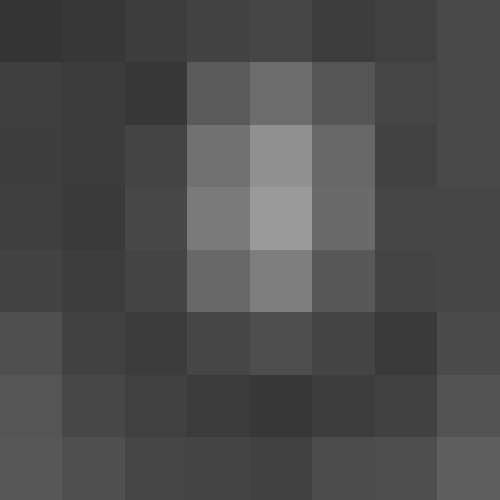

In [16]:
show_arr(I)

In [17]:
I

array([[ 52,  55,  61,  66,  70,  61,  64,  73],
       [ 63,  59,  55,  90, 109,  85,  69,  72],
       [ 62,  59,  68, 113, 144, 104,  66,  73],
       [ 63,  58,  71, 122, 154, 106,  70,  69],
       [ 67,  61,  68, 104, 126,  88,  68,  70],
       [ 79,  65,  60,  70,  77,  68,  58,  75],
       [ 85,  71,  64,  59,  55,  61,  65,  83],
       [ 87,  79,  69,  68,  65,  76,  78,  94]])

And the one we compressed:

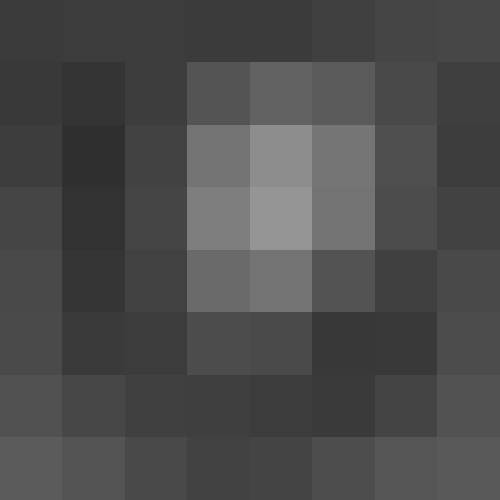

In [18]:
show_arr(_I)

In [19]:
_I

array([[ 59.53600012,  60.88612722,  60.78742912,  59.2773395 ,
         59.90382799,  64.08191242,  69.01345141,  71.78923396],
       [ 57.71514823,  52.78415377,  61.6126308 ,  84.72169533,
         98.47694098,  90.291222  ,  73.49597995,  63.62235796],
       [ 61.40312959,  47.92584165,  66.22544309, 116.35086565,
        141.70943524, 117.14979544,  79.07723159,  60.5627253 ],
       [ 69.40423568,  50.12737124,  69.87488216, 126.79392839,
        149.56979994, 115.30599074,  76.99777766,  66.80057639],
       [ 73.43195578,  53.70162947,  65.75032514, 106.33854362,
        115.3479698 ,  83.89551918,  64.95963034,  73.45115352],
       [ 74.7933654 ,  58.99665507,  60.05674643,  76.38593875,
         74.22396066,  56.0608229 ,  57.58985604,  76.94865962],
       [ 81.81932002,  71.241129  ,  64.18445834,  63.61493012,
         60.91001116,  58.89064701,  68.41738693,  82.74151598],
       [ 91.35877166,  84.23265155,  73.66664225,  66.66361834,
         68.49875031,  77.109065 

Let's take a look at the difference now. Here, we check the difference between the original matrix and the matrix after decompression

Note: The whitest it is, the closest to the original matrix it is. For instance, the difference between two same pictures is a white picture.

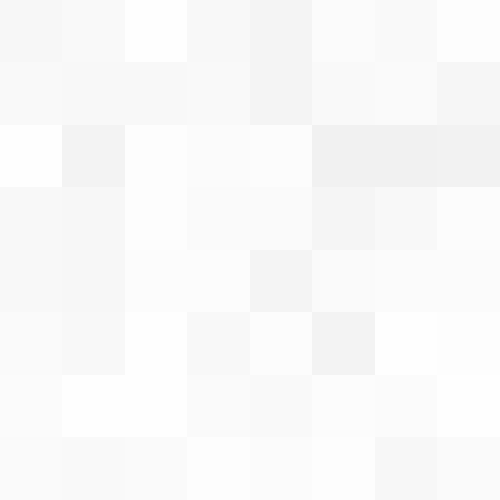

In [20]:
show_arr(255 - np.abs(I - _I))

We can see the compression/decompression worked quite well since the result of the difference is mostly white.

# Part 2: Full grayscale image
So far, we have showed the compression and decompression of a 8x8 image. But images are usually not 8x8 images. Our algorithm is fantastic, but needs a bit more to be really usable. Let's improve it to be able to compress and decompress full grayscale images.

In [21]:
# Load an image in black and white, remove its alpha channel and returns it as a numpy array
def load_grayscale(path):
    im = Image.open(path).convert('LA')
    arr = np.array(im)
    arr = arr[:,:,:-1]
    return arr[:,:,0]

## Compression

### Compression step 1: Separates chunks
The first step once the image is loaded is to separate it in several blocks of 8x8. Since the image is not always in dimensions that are multiple of 8, we will need to add padding at the end of the last chunks to make sure every chunk is full.

In [22]:
# Return a numpy array containing chunks of 8x8 pixels (It is then an x*y*8*8 array) 
# and the dimensions of the image
def separateChuncks(array, chunk_size = 8):
    # Chunks dimensions
    (arrX, arrY) = array.shape
    (x, y) = (int(np.ceil(arrX / chunk_size)), int(np.ceil(arrY / chunk_size)))
    
    # Create the chunks array
    chunks = np.zeros((x, y, chunk_size, chunk_size))
    
    # Iterate chunk
    for (i, j) in np.ndindex(x, y):
        # The point we start from in array
        (startX, startY) = (i * chunk_size, j * chunk_size)
        
        # The limit of the chunk for the padding
        (clipX, clipY) = (arrX % chunk_size if startX + chunk_size > arrX else chunk_size, arrY % chunk_size if startY + chunk_size > arrY else chunk_size)
        
        # Copy the 8x8 chunk
        chunks[i, j][:clipX, :clipY] = array[startX:startX + clipX, startY:startY + clipY]
        
    return (chunks, (arrX, arrY))

### Compression step 2: Compress the chunks

Here we will apply the functions created in part 1 to a single chunk...

In [23]:
def compressChunk(chunk, D8, Q):
    J = D8 @ (chunk - 128) @ D8.T
    J = np.around(J).astype(int)
    K = J / Q
    K = np.around(K).astype(int)
    zig = zigzag(K)
    zig_without_zero = eliminate_zero(zig)
    ratio = 1
    if len(zig_without_zero) != 0:
        ratio = len(zig) / len(zig_without_zero)
    return zig_without_zero, ratio

... and do it for every chunk.
We put everything in a ``compress`` function to be more easily used.

In [24]:
# Compress function
# Takes as argument the arr being compressed and the quality of the compression.
# Returns a list of linearized 8x8 blocks, the picture dimensions, and all blocks compression ratio
def compress(arr, quality = 50):
    D8 = create_D8()
    Q = create_Q(quality)
    chunks, dimensions = separateChuncks(arr)
    x, y, _, _ = chunks.shape
    zigs = []
    compression_ratios = np.zeros((x, y), dtype = float)
    for (i, j) in np.ndindex(x, y):
        if i >= len(zigs):
            zigs.append([])
        zig_without_zero, ratio = compressChunk(chunks[i][j], D8, Q)
        zigs[i].append(zig_without_zero)
        compression_ratios[i][j] = ratio
    return zigs, dimensions, compression_ratios

## Decompression

### Decompression step 1: combine chunks
In order to finish the decompression, we will need to combine the different chunks into a single matrix.

In [25]:
# Recreate the original array from chunks
def combineChunks(chunks, dimensions, chunk_size = 8):
    # Array outputed
    array = np.empty(dimensions)
    
    for (i, j, cx, cy) in np.ndindex(chunks.shape):
        # Coordinate of the pixel
        (x, y) = i * chunk_size + cx, j * chunk_size + cy
        if (x < dimensions[0] and y < dimensions[1]):
            array[x, y] = chunks[i, j, cx, cy]
    
    return array

### Decompression step 2: decompress everything
Let's do the opposite operations of ``compress`` in a ``decompress`` function.

Note: Bounds are used to avoid overflow. For instance, in the RGB space the upper bound is 255. No values can be greater than 255. In the same way, no values can be lower than 0. In other color space such as YUV color, the bounds are different

In [26]:
# Decomrpess function
# Takes as arguments: list of linearized blocks, the picture dimensions, the quality of compression/decompression
# and the bounds described above.
# Return the decompressed image
def decompress(zigs, dimensions, quality = 50, lower_bound = 0, upper_bound = 255):
    D8 = create_D8()
    Q = create_Q(quality)
    x = len(zigs)
    y = len(zigs[0])
    chunks = np.zeros((x, y, 8, 8))
    for (i, j) in np.ndindex(x, y):
        _zig = read_zero(zigs[i][j])
        _K = zigzag_reverse(_zig)
        _J = _K * Q
        _arr88 = (D8.T @ _J @ D8) + 128
        _arr88[_arr88 > upper_bound] = upper_bound
        _arr88[_arr88 < lower_bound] = lower_bound
        chunks[i][j] = _arr88
    _arr = combineChunks(chunks, dimensions)
    return _arr
        

### Time to see the results!
Let's try it on an image to see how it works!

Note: If you want to try with another picture, change the path variable defined at the very begining of this notebook. Also, feel free to change the quality rate defined in the same cell as the path.

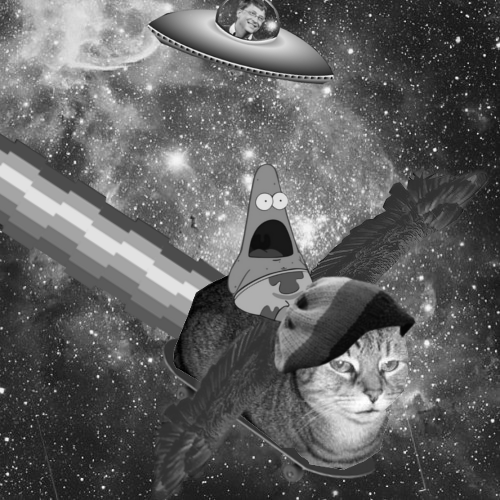

In [27]:
# The original picture
arr = load_grayscale(path)
show_arr(arr)

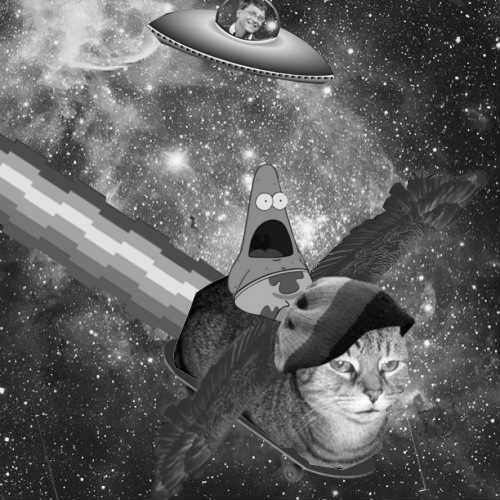

In [28]:
zigs, dimensions, compression_ratios = compress(arr, q)
_arr = decompress(zigs, dimensions, q)
# The decompressed image
show_arr(_arr)

With a quality rate of 50, the grayscale picture looks alike the original picture. Thus, the compression/decompression seems to be successful. However, we can see the quality of the picture is lower on some specific part.

### Compression ratio

Let's check out how much we overall compressed the picture.

Firstly, the average ratio between all chunks is computed.

Secondly, the ratio is showed by block. Closer the block is to black, greater the compression is. 

In [29]:
def compute_average_ratio(compression_ratios):
    _sum = 0
    for (i, j) in np.ndindex(compression_ratios.shape):
        _sum += compression_ratios[i][j]
    _sum /= compression_ratios.shape[0] * compression_ratios.shape[1]
    return _sum

_sum = compute_average_ratio(compression_ratios)
print(f"Average compression ratio: {_sum}")

Average compression ratio: 4.794104214474454


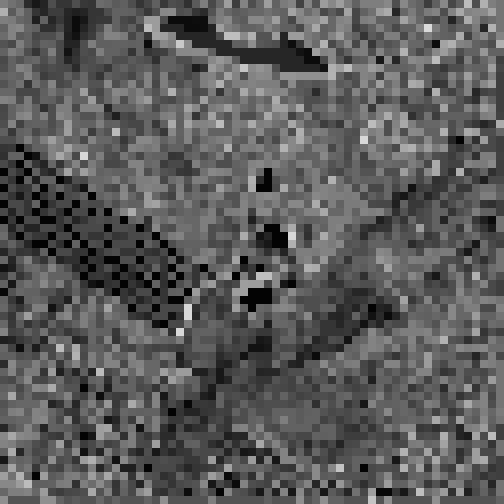

In [30]:
def show_ratio(compression_ratios):
    arr_compression = np.zeros((compression_ratios.shape[0] * 8, compression_ratios.shape[1] * 8), dtype=int)
    for (i, j) in np.ndindex(arr_compression.shape):
        arr_compression[i][j] = int(1 / compression_ratios[int(i / 8)][int(j / 8)] * 255)
    return show_arr(arr_compression)

show_ratio(compression_ratios)

And the error:

Note: The error is null when the gray is around 128. If the gray is way greater or lower than 128 then the error is important.

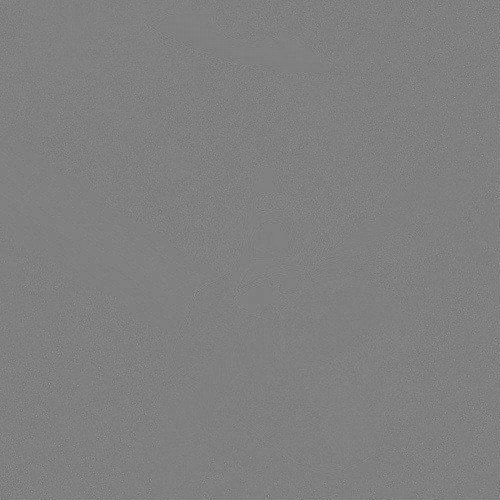

In [31]:
arr = load_grayscale(path)
show_arr(128 + arr - _arr)

# Part 3: Colors

## RGB color space

In order to compress a RGB picture, we simply compress/decompress seperatly the three channels as a gray channel.
Thus, we basically load the red, green and blue channel and call compress on these channels. For the decompression, decompress is call on each of the channels. Finally, the decompressed RGB picture is created with the three decompressed channels.

In [32]:
def load_rgb(path):
    im = Image.open(path)
    arr = np.array(im)
    return arr[:,:,0], arr[:,:,1], arr[:,:,2]
 
arr_r, arr_g, arr_b = load_rgb(path)

# compress red
zigs_r, dimension, compression_ratios_r = compress(arr_r, q)
_arr_r = decompress(zigs_r, dimensions, q)

# compress green
zigs_g, dimension, compression_ratios_g = compress(arr_g, q)
_arr_g = decompress(zigs_g, dimensions, q)

# compress blue
zigs_b, dimension, compression_ratios_b = compress(arr_b, q)
_arr_b = decompress(zigs_b, dimensions, q)

Let's see the three decompressed channels:

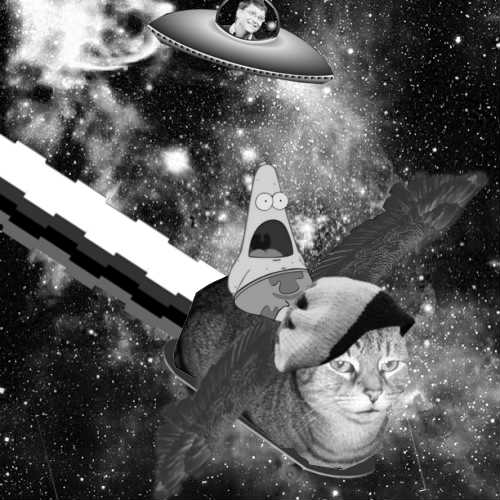

In [33]:
show_arr(_arr_r) # red

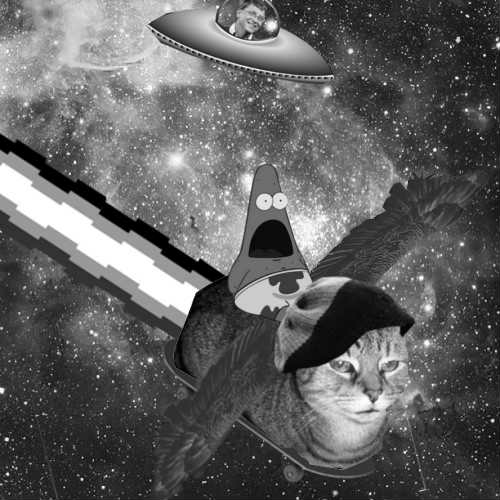

In [34]:
show_arr(_arr_g) # green

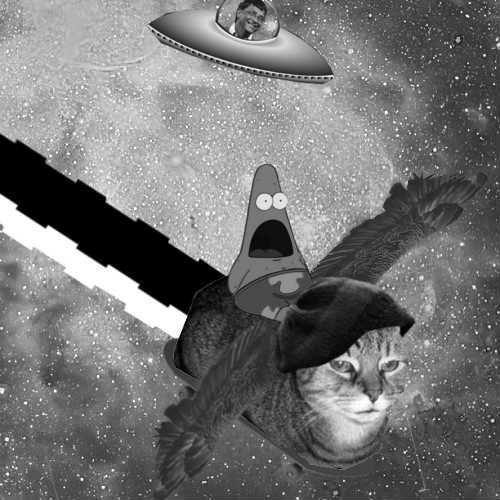

In [35]:
show_arr(_arr_b) # blue

Now, let's also show the three channels associated to be in a RGB image.

In [36]:
def show_rgb(arr_r, arr_g, arr_b):
    x, y = arr_r.shape
    arr2 = np.zeros((x, y, 4), dtype = int)
    arr2[:,:,0] = arr_r[:,:]
    arr2[:,:,1] = arr_g[:,:]
    arr2[:,:,2] = arr_b[:,:]
    arr2[:,:,3] = 255
    if x == 8 and y == 8: # resize chunk
        return Image.fromarray(np.uint8(arr2)).resize((500,500), Image.NEAREST)
    else:
        return Image.fromarray(np.uint8(arr2))

Below is displayed the decompressed RGB picture.

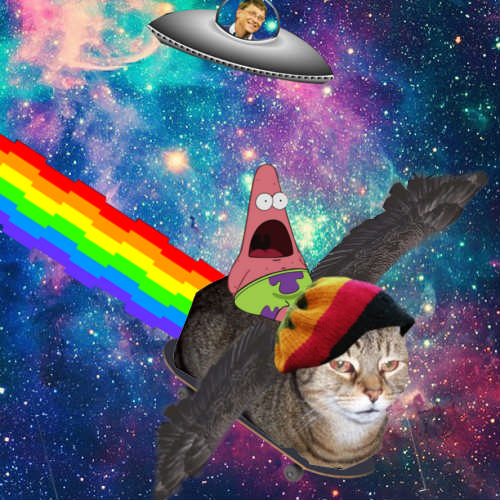

In [37]:
show_rgb(_arr_r, _arr_g, _arr_b)

On the below picture, the error for each channel is displayed. We can see the compression is not so great since some colors appears and the picture is not fully middle gray.

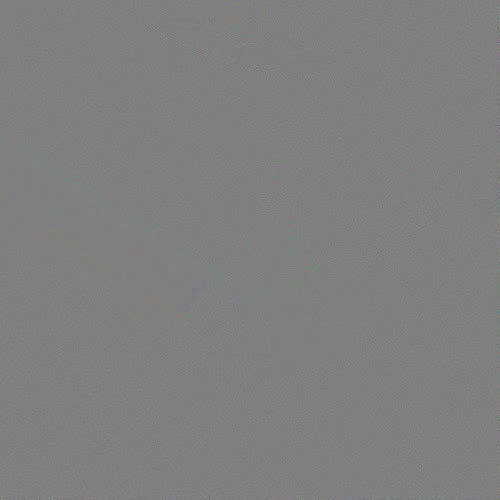

In [38]:
show_rgb(_arr_r - arr_r + 128, _arr_g - arr_g + 128, _arr_b - arr_b + 128)

Finally, let's compute some compression ratio.

As for the gray image, the average ratio for all blocks is computed. In this case, we sum up the three ratios (for the three channels).

In [39]:
def compute_average_ratio_rgb(compression_ratios_r, compression_ratios_g, compression_ratios_b):
    _sum = 0
    for (i, j) in np.ndindex(compression_ratios_r.shape):
        _sum += compression_ratios_r[i][j]
        _sum += compression_ratios_g[i][j]
        _sum += compression_ratios_b[i][j]
    _sum /= compression_ratios_r.shape[0] * compression_ratios_r.shape[1] * 3
    return _sum

ratio_rgb = compute_average_ratio_rgb(compression_ratios_r, compression_ratios_g, compression_ratios_b)
print(f"The average compression ratio is {ratio_rgb}")

The average compression ratio is 6.000030653660255


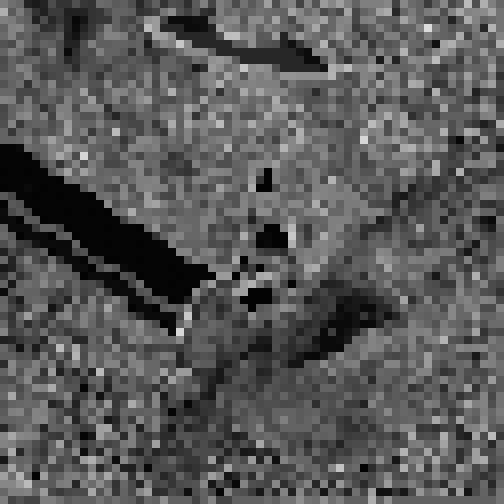

In [40]:
def show_ratio_rgb(compression_ratios_r, compression_ratios_g, compression_ratios_b):
    arr_compression = np.zeros((compression_ratios_r.shape[0] * 8, compression_ratios_r.shape[1] * 8), dtype=int)
    for (i, j) in np.ndindex(arr_compression.shape):
        av = compression_ratios_r[int(i / 8)][int(j / 8)] + compression_ratios_g[int(i / 8)][int(j / 8)] + compression_ratios_b[int(i / 8)][int(j / 8)]
        av /= 3
        arr_compression[i][j] = int(1 / av * 255)
    return show_arr(arr_compression)

show_ratio_rgb(compression_ratios_r, compression_ratios_g, compression_ratios_b)

## YUV color space

Simple demonstration converting from RGB to YUV and back to RGB before display

In [41]:
RGB_TO_YUV = np.array([[0.299, 0.587, 0.114],
                       [-0.14713, -0.28886, 0.436],
                       [0.615, -0.51499, -0.10001]])
                       
YUV_TO_RGB = np.array([[1, 0, 1.13983],
                       [1, -0.39465, -0.58060],
                       [1, 2.03211, 0]])

def load_yuv(path):
    im = Image.open(path)
    arr = np.array(im)
    if arr.shape[2] > 3:
        arr = arr[:,:,0:3]
    x, y, _ = arr.shape
    yuv = np.empty((x, y, 3))
    for (i, j) in np.ndindex(x, y):
        yuv[i, j, :] = RGB_TO_YUV @ arr[i,j,:]
    return yuv[:,:,0], yuv[:,:,1], yuv[:,:,2]

def rgb_from_yuv(arr_y, arr_u, arr_v):
    x, y = arr_y.shape
    yuv = np.empty((x, y, 3))
    yuv[:,:,0] = arr_y
    yuv[:,:,1] = arr_u
    yuv[:,:,2] = arr_v
    rgb = np.empty((x, y, 3))
    for (i, j) in np.ndindex(x, y):
        rgb[i, j, :] = YUV_TO_RGB @ yuv[i,j,:]
    arr_r, arr_g, arr_b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2] 
    arr_r[arr_r > 255] = 255
    arr_r[arr_r < 0] = 0
    arr_g[arr_g > 255] = 255
    arr_g[arr_g < 0] = 0
    arr_b[arr_b > 255] = 255
    arr_b[arr_b < 0] = 0
    return arr_r, arr_g, arr_b

arr_y, arr_u, arr_v = load_yuv(path)

Converting back to RGB to display the result

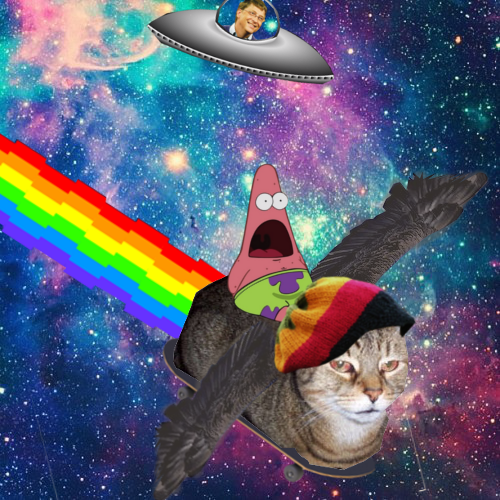

In [42]:
arr_r, arr_g, arr_b = rgb_from_yuv(arr_y, arr_u, arr_v)
show_rgb(arr_r, arr_g, arr_b)

### 4:4:4 Compression in the YUV color space

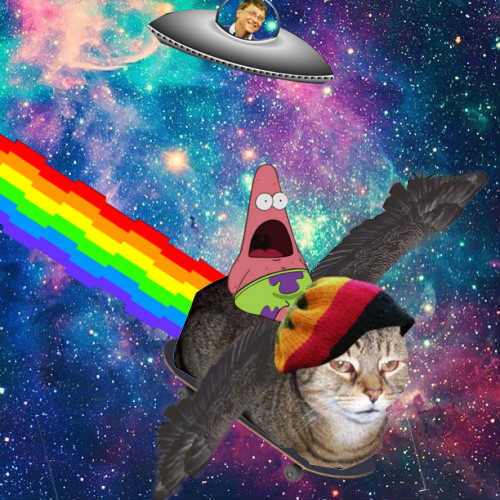

In [43]:
# resize 4:4:4

# compress Y
zigs_y, dimension, compression_ratios_y = compress(arr_y, q)
_arr_y = decompress(zigs_y, dimension, q)

# compress U
zigs_u, dimension, compression_ratios_u = compress(arr_u, q)
# We need to specify the specific U channel boundaries
_arr_u = decompress(zigs_u, dimension, q, -111.18, 111.18)

# compress V
zigs_v, dimension, compression_ratios_v = compress(arr_v, q)
# We need to specify the specific V channel boundaries
_arr_v = decompress(zigs_v, dimension, q, -156.825, 156.825)

_arr_r, _arr_g, _arr_b = rgb_from_yuv(_arr_y, _arr_u, _arr_v)
show_rgb(_arr_r, _arr_g, _arr_b)

In [44]:
compute_average_ratio_rgb(compression_ratios_y, compression_ratios_u, compression_ratios_v)

17.658086551603905

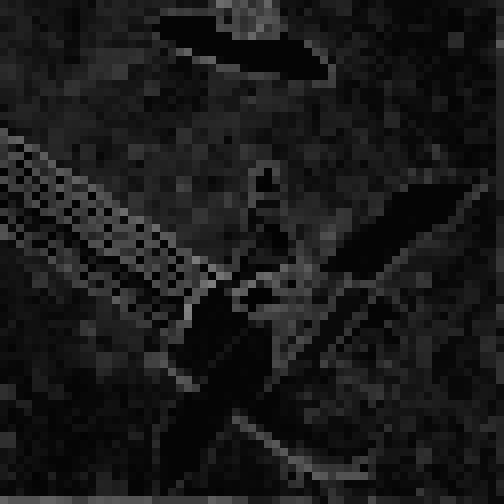

In [45]:
show_ratio_rgb(compression_ratios_y, compression_ratios_u, compression_ratios_v)

The blocks ratio are closer to black than after decompression by using the RGB color space. Thus, it seems the blocks ratio are greater by using the YUV color space than the RGB color space. The overall compression ratio seems better by using YUV color space.

The RGB difference with the original image:

Note: we transformed the error in YUV color space to RGB color space to make it clearer.

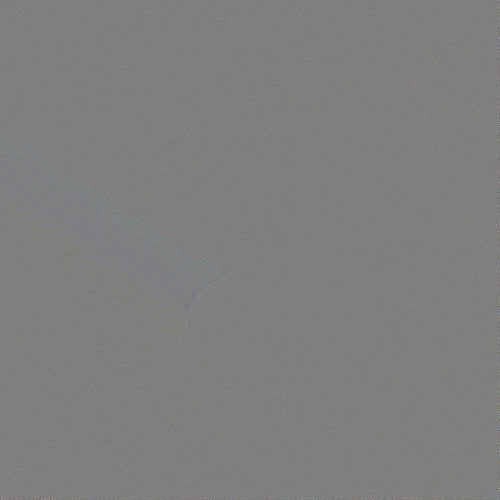

In [46]:
show_rgb(_arr_r - arr_r + 128, _arr_g - arr_g + 128, _arr_b - arr_b + 128) # Error on YUV in RGB

### 4:2:2 Downsampling scheme

Because our eyes are more sensible to the luminance than the colors, we can discard more of the color information without losing too much quality.

The 4:2:2 downsampling scheme benefit of this by downsampling the U and V channel by two on the horizontal axis but keeping the original size of the Y channel.
This compression method work better for landskapes where there is little color change over the horizontal axis (the sky, the groud)

Demonstration of the 4:2:2 compression

The resize function used to resize the U and V color channel for 4:2:2 and 4:2:0 compression

In [47]:
def resize(arr, x, y):
    # axis_y rows
    # axis_x columns
    scale_x = arr.shape[0] / x
    scale_y = arr.shape[1] / y
    res = np.zeros((x, y), dtype = int)
    for i in range(x):
        for j in range(y):
            res[i][j] = arr[int(i * scale_x)][int(j * scale_y)]
    return res

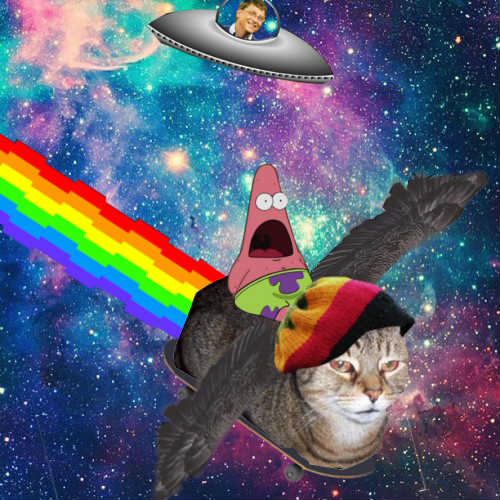

In [48]:
# resize 4:2:2

# Resize U, V
arr_u_resized = resize(arr_u, arr_u.shape[0], int(arr_u.shape[1] / 2))
arr_v_resized = resize(arr_v, arr_v.shape[0], int(arr_v.shape[1] / 2))

# compress Y
zigs_y, dimension, _ = compress(arr_y, q)
_arr_y = decompress(zigs_y, dimension, q)

# compress U
zigs_u, dimension, _ = compress(arr_u_resized, q)
# We need to specify the specific U channel boundaries
_arr_u_resized = decompress(zigs_u, dimension, q, -111.18, 111.18)

# compress V
zigs_v, dimension, _ = compress(arr_v_resized, q)
# We need to specify the specific V channel boundaries
_arr_v_resized = decompress(zigs_v, dimension, q, -156.825, 156.825)

_arr_u = resize(_arr_u_resized, _arr_y.shape[0], _arr_y.shape[1])
_arr_v = resize(_arr_v_resized, _arr_y.shape[0], _arr_y.shape[1])

_arr_r, _arr_g, _arr_b = rgb_from_yuv(_arr_y, _arr_u, _arr_v)
show_rgb(_arr_r, _arr_g, _arr_b)

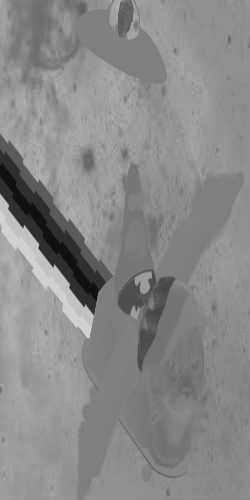

In [49]:
show_arr(_arr_u_resized + 128)

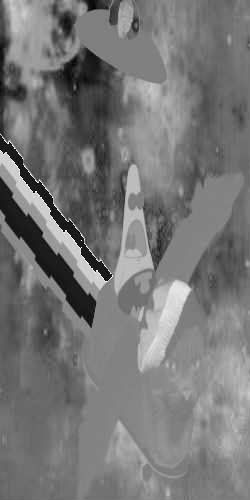

In [50]:
show_arr(_arr_v_resized + 128)

Let's check the error rates:

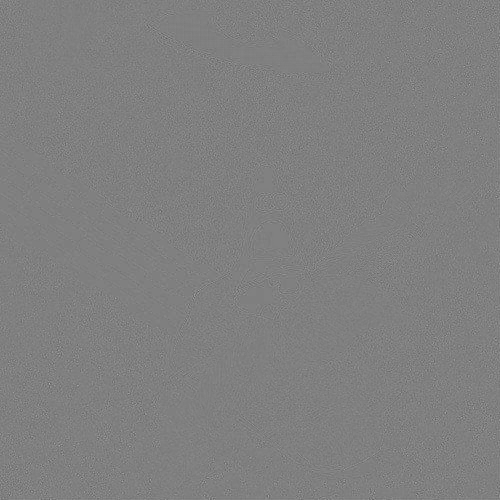

In [51]:
show_arr(arr_y - _arr_y + 128) # Error on the Y channel

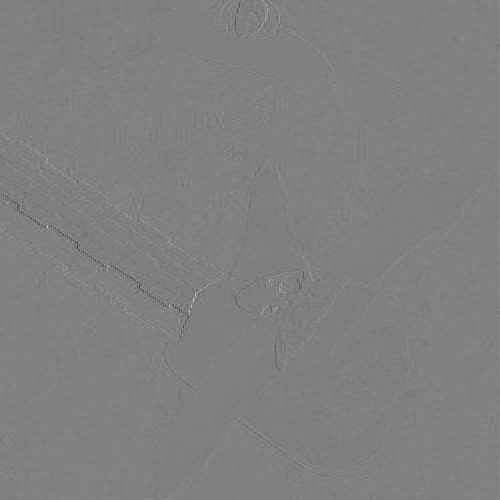

In [52]:
show_arr(arr_u - _arr_u + 128) # Error on the U channel

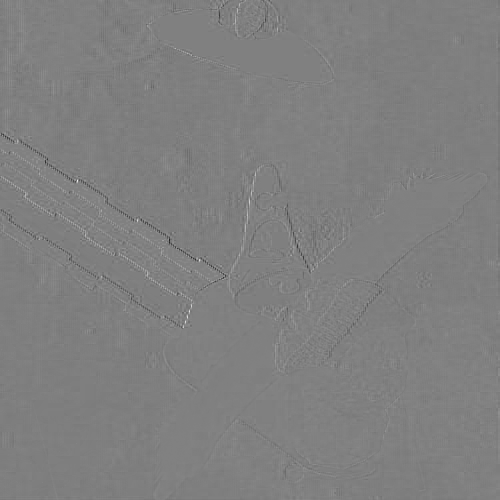

In [53]:
show_arr(arr_v - _arr_v + 128) # Error on the V channel

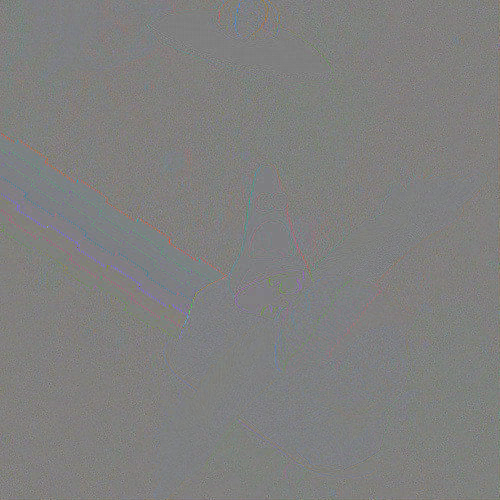

In [54]:
show_rgb(_arr_r - arr_r + 128, _arr_g - arr_g + 128, _arr_b - arr_b + 128) # Error on YUV in RGB

### 4:2:0 Downsampling scheme

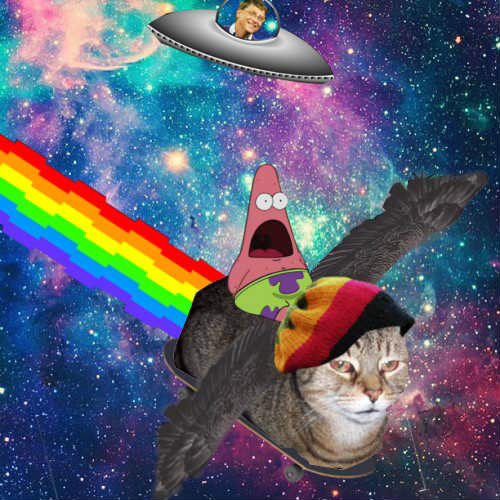

In [55]:
# resize 4:2:0

# Resize U, V
arr_u_resized = resize(arr_u, int(arr_u.shape[0] / 2), int(arr_u.shape[1] / 2))
arr_v_resized = resize(arr_v, int(arr_v.shape[0] / 2), int(arr_v.shape[1] / 2))

# compress Y
zigs_y, dimension, _ = compress(arr_y, q)
_arr_y = decompress(zigs_y, dimension, q)

# compress U
zigs_u, dimension, _ = compress(arr_u_resized, q)
# We need to specify the specific U channel boundaries
_arr_u_resized = decompress(zigs_u, dimension, q, -111.18, 111.18)

# compress V
zigs_v, dimension, _ = compress(arr_v_resized, q)
# We need to specify the specific V channel boundaries
_arr_v_resized = decompress(zigs_v, dimension, q, -156.825, 156.825)

_arr_u = resize(_arr_u_resized, _arr_y.shape[0], _arr_y.shape[1])
_arr_v = resize(_arr_v_resized, _arr_y.shape[0], _arr_y.shape[1])

_arr_r, _arr_g, _arr_b = rgb_from_yuv(_arr_y, _arr_u, _arr_v)
show_rgb(_arr_r, _arr_g, _arr_b)

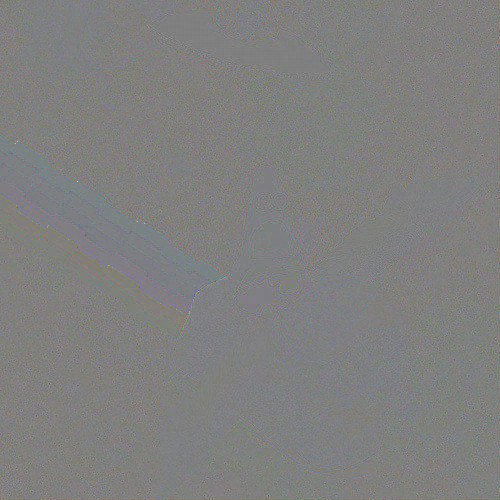

In [56]:
show_rgb(_arr_r - arr_r + 128, _arr_g - arr_g + 128, _arr_b - arr_b + 128) # Error on YUV in RGB